In [1]:
# reading in the libraries and functions that we will need as we do this work.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
import scipy.stats as st
import statsmodels.api as sm 
import pylab as py 

# here are some of the tools we will use for our analyses
from sklearn.linear_model import LinearRegression
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

### Outliers, Leverage, Influence

In this Jupyter Notebook we will look at outliers, leverage points and influence points.  Leverage
is a function of where a value or observation falls relative to the other data.  If it is far from other
observations then it potentially has leverage to change our prediction equation.

An influential point is one that has both a large leverage and large residual (when that point 
is removed) so that it seems to be *influencing* the prediction equation.

We'll start with the blue jay data below.



In [2]:
# read in the blue jay data
bluejay = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/BlueJays.csv", na_values=['NA'])
# remove rows with missing data
bluejay.dropna(inplace=True)
bluejay.head()

,Unnamed: 0,BirdID,KnownSex,BillDepth,BillWidth,BillLength,Head,Mass,Skull,Sex
0,1,0000-00000,M,8.26,9.21,25.92,56.58,73.30,30.66,1
1,2,1142-05901,M,8.54,8.76,24.99,56.36,75.10,31.38,1
2,3,1142-05905,M,8.39,8.78,26.07,57.32,70.25,31.25,1
3,4,1142-05907,F,7.78,9.30,23.48,53.77,65.50,30.29,0
4,5,1142-05909,M,8.71,9.84,25.47,57.32,74.90,31.85,1


In [3]:

# below we build a multiple regression model with three predictors
#  Predictors here are Head, BillDepth, and BillLength
# Our target variable will be the Mass of the blue jay 

X = bluejay[['Head', 'BillDepth', 'BillLength']]  
y = bluejay['Mass']  


# Create a linear regression model
blue_model = LinearRegression()

# Fit the model on the  data
blue_model.fit(X, y)

# Make predictions on the  data
y_hat = blue_model.predict(X)

# Evaluate the model performance
rmse = root_mean_squared_error(y, y_hat)
print('Root Mean Squared Error:', rmse)

# Get the coefficients and intercept
print('Coefficients:', blue_model.coef_)
print('Intercept:', blue_model.intercept_)

Root Mean Squared Error: 3.479851526257172
Coefficients: [ 2.44658643  2.80717324 -1.51437269]
Intercept: -50.200115130365205


In [4]:
# for this particular model formulation we need to add a 
# column of 1's to the feature array
#add constant to predictor variables
x2 = sm.add_constant(X)

#fit linear regression model using OLS
blue_model2 = sm.OLS(y, x2).fit()

#view model summary
print(blue_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Mass   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     34.16
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           5.35e-16
Time:                        09:49:58   Log-Likelihood:                -327.91
No. Observations:                 123   AIC:                             663.8
Df Residuals:                     119   BIC:                             675.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.2001     12.237     -4.102      0.0

In [5]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x2.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x2.values, i)
                          for i in range(len(x2.columns))]

print(vif_data[1:len(x2.columns)])

      feature       VIF
1        Head  3.131312
2   BillDepth  1.513932
3  BillLength  3.103693


Multicollinearity does not seem to be a problem here.

In [6]:
# Calculate leverage statistics
leverage = blue_model2.get_influence().hat_matrix_diag
print(leverage)



[0.01769914 0.01539725 0.01862966 0.02337729 0.02588682 0.06679226
 0.0267779  0.1837628  0.04972911 0.02986487 0.02549429 0.01481534
 0.03236266 0.04425853 0.03684287 0.03931699 0.01958085 0.07611678
 0.01568506 0.01438783 0.03146296 0.01733008 0.04241685 0.01857962
 0.01781666 0.01348543 0.05956581 0.02299464 0.02235227 0.02363865
 0.06554676 0.05323552 0.01835699 0.01064547 0.01859694 0.01110663
 0.02446807 0.01855107 0.03564568 0.01716676 0.03217252 0.0280971
 0.03122198 0.02645467 0.02689555 0.01447067 0.03314733 0.03370136
 0.01311328 0.04646857 0.00878197 0.01417132 0.01908395 0.02470595
 0.03024513 0.03552391 0.02810434 0.02841125 0.05717501 0.01955323
 0.04611265 0.04302854 0.04199828 0.03625711 0.02327471 0.0273865
 0.0314855  0.03514323 0.04633819 0.0758518  0.00995325 0.02070169
 0.01296391 0.06599432 0.03896817 0.01974561 0.01275597 0.00887027
 0.03264854 0.02747927 0.02541632 0.09749463 0.0477475  0.02606724
 0.04075364 0.0473311  0.03064972 0.03574456 0.04164473 0.050361

The above are our leverage values.  We're only going to worry if any of them are more
than $2*(k+1)/n =2*4/123 = 0.0650$ where $k$ is the number of predictors.  

In [7]:
# Calculate Cook's distance
cook_distance = blue_model2.get_influence().cooks_distance[0]
print(np.round(cook_distance,4))

[0.0005 0.0005 0.0058 0.0022 0.0006 0.0003 0.0002 0.0037 0.0141 0.0008
 0.0035 0.0017 0.0067 0.0037 0.009  0.0052 0.0164 0.0089 0.0063 0.0014
 0.0024 0.     0.0002 0.0197 0.     0.0396 0.0021 0.0081 0.0002 0.0023
 0.0002 0.0122 0.0107 0.0001 0.0003 0.0024 0.0021 0.0021 0.0002 0.0094
 0.0472 0.0023 0.0355 0.0004 0.0333 0.004  0.0134 0.0068 0.0032 0.0001
 0.0018 0.0006 0.0006 0.0349 0.0027 0.0178 0.0009 0.0046 0.     0.0012
 0.0157 0.0026 0.0036 0.0214 0.0002 0.0039 0.0002 0.0033 0.0065 0.0186
 0.0002 0.     0.0006 0.0034 0.     0.0007 0.0012 0.0001 0.0003 0.0007
 0.0112 0.0636 0.0106 0.0261 0.0047 0.016  0.01   0.0002 0.0079 0.0354
 0.0148 0.0001 0.     0.0053 0.0218 0.0095 0.003  0.033  0.     0.0055
 0.0008 0.0001 0.0007 0.0002 0.0072 0.0102 0.02   0.0006 0.0277 0.0015
 0.0389 0.001  0.0079 0.0031 0.0005 0.0023 0.0001 0.0151 0.0019 0.0019
 0.0072 0.0084 0.    ]


The above are our cooks distance values.  We will be concerned if any of them are more than
$0.5$ and we will be very concerned if any are more than $1.0$.

In [8]:
# Calculate studentized residuals
# recall that standardized residuals are residuals divided by standard deviation of all the residuals.
# 
# studentized residuals are residuals divided by standard deviation of the residuals if 
# the particular residual is not included.

studentized_residuals = blue_model2.get_influence().resid_studentized_external

print(studentized_residuals)

[ 0.32319593  0.36368998 -1.10256364 -0.6090869  -0.29031269 -0.13854246
 -0.16956743  0.2550213  -1.03677172 -0.32810974  0.7352493   0.67116018
  0.89612244  0.56708681  0.9691975  -0.71029644  1.82747632 -0.65719999
  1.25898475 -0.62024445 -0.537634   -0.01354846  0.13072719  2.06731852
 -0.02083572 -3.5656077  -0.3661184   1.17573425 -0.19572628  0.61318245
  0.11826494  0.92988721  1.5210287  -0.18165016 -0.2618337  -0.91563814
 -0.57182118 -0.66334595  0.13582811  1.47186073 -2.43277129  0.56585729
 -2.12859975  0.22708923  2.23113522  1.0472518   1.25223627 -0.88101775
 -0.98096789 -0.08130245 -0.9045722   0.39744982 -0.33705553 -2.3922138
 -0.58517296 -1.39680758 -0.34739161 -0.79345628 -0.01523526 -0.48903619
 -1.14200213 -0.4777138  -0.57532504  1.51566315  0.18692733 -0.73942531
 -0.16860987  0.59790293 -0.73273893 -0.9526672   0.29024592  0.01802785
  0.42024652  0.435522   -0.06956934  0.38134001  0.60551288 -0.25349482
  0.18723872  0.3237563  -1.31395265 -1.5438072  -0.

In [9]:

# here we will identify any that are of concern


# Identify large leverage points
leverage_points = np.where(leverage > np.mean(leverage) + 2 * np.std(leverage))
print(leverage_points)

# Identify influential observations based on Cook's distance
influential_observations = np.where(cook_distance > 0.5)
print(influential_observations)

x=bluejay['Head']
y=bluejay['Mass']


(array([ 7, 17, 69, 81]),)
(array([], dtype=int64),)


The leverage points are 7, 17, 69 and 81 which correspond to the row numbers for those data.

There do not appear to be any influential points.  Let's look at them.

In [10]:
print(bluejay.loc[leverage_points])

    Unnamed: 0      BirdID KnownSex  BillDepth  BillWidth  BillLength   Head  \
7            8  1142-05914        M       8.72       9.94        30.0  60.67   
17          18  1142-05991        M       8.19       9.98        25.4  58.70   
69          70   952-00066        F       7.30       9.90        22.4  53.90   
81          82   952-00080        M       8.80       9.80        27.3  56.20   

    Mass  Skull  Sex  
7   78.1  30.67    1  
17  75.7  33.30    1  
69  65.0  31.50    0  
81  65.5  28.90    1  


Hard to identify what these are leverage points without some additional information.  Let's look at the mean 
and standard deviation for the variables that are predictors/features.

In [11]:
print("Mean of Bill Depth is ", np.round(np.mean(bluejay['BillDepth']),2))
print("Standard deviation of Bill Depth is ", np.round(np.std(bluejay['BillDepth']),2))
print("Mean of Head is ", np.round(np.mean(bluejay['Head']),2))
print("Standard deviation of Head is ", np.round(np.std(bluejay['Head']),2))
print("Mean of Bill Length is ", np.round(np.mean(bluejay['BillLength']),2))
print("Standard deviation of Bill Length is ", np.round(np.std(bluejay['BillLength']),2))

Mean of Bill Depth is  8.23
Standard deviation of Bill Depth is  0.39
Mean of Head is  55.69
Standard deviation of Head is  1.56
Mean of Bill Length is  24.84
Standard deviation of Bill Length is  1.17


Now we can get a sense of why the four values that were chosen were leverage points.  Below large(small) is measured
in number of standard deviations above(below) the mean.

For the first one, the head size is very large as is the bill length.

For the second one, head size seems to be very large.

For the third one, all of the predictors are very small.

For the fourth one, bill length seems to be the variable that likely is leading to a large leverage.

In [12]:
# read in the data to dataframe called ames
ames = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/Ames_house_prices.csv", na_values=['?'])
# replace the ? in the data with NaN for missing values
ames.replace([' ?'],np.nan)
# show information about the dataframe
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

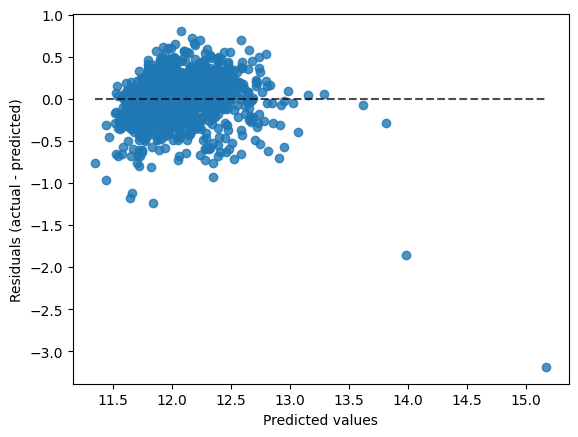

In [13]:

model1=LinearRegression()

X = ames[['LotArea', 'GrLivArea', 'BsmtFinSF1']]
# going to make a transformation of the SalePrice by
# taking the natural logarithm of it.
y = np.log(ames['SalePrice'])

# fit the linear regression to the data.
model1.fit(X,y)

# make the residual vs fitted plot
y_hat = model1.predict(X)
# below makes a 
display = PredictionErrorDisplay(y_true=y, y_pred=y_hat)
display.plot()
plt.show()


In [14]:
x2 = sm.add_constant(X)

#fit linear regression model using OLS
model1 = sm.OLS(y, x2).fit()

In [15]:
# Calculate leverage statistics
leverage = model1.get_influence().hat_matrix_diag
cook_distance = model1.get_influence().cooks_distance[0]
studentized_residuals = model1.get_influence().resid_studentized_external



# Identify large leverage points
leverage_points = np.where(leverage > np.mean(leverage) + 2 * np.std(leverage))
print("These are the leverage points")
print(leverage_points)

# Identify influential observations based on Cook's distance
influential_observations = np.where(cook_distance > 0.5)
print("These are the influential points")
print(influential_observations)


These are the leverage points
(array([ 249,  313,  335,  451,  523,  706, 1182, 1298]),)
These are the influential points
(array([1298]),)


In [16]:
So here we have some leverage points, eight of them. And one influential point, in row 1298.

SyntaxError: invalid syntax (651476626.py, line 1)

In [ ]:
print(ames.loc[influential_observations])


That SalePrice seems low but it is hard to tell from the output we got.  Let's make it bit more 
targeted.

In [ ]:
print(ames[['LotArea', 'GrLivArea', 'BsmtFinSF1','SalePrice']].loc[influential_observations])

So the SalePrice seems low for such a large house.  Let's look at the studentized residual for this.

In [ ]:
print(studentized_residuals[influential_observations])

That's quite a negative residual and, no doubt, the reason that there are 

### Tasks

1. Fit a multiple regression to the penguins data with body mass as the response and flipper length and 
bill length as features.

2. Determine if there are any unusual residuals, any leverage points or any influential points in the regression
that you made in the previous task.